In [1]:
%matplotlib inline
%matplotlib widget
%load_ext autoreload
%autoreload 2

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
from matplotlib.colors import ListedColormap

import matplotlib.pyplot as plt
import numpy as np

import vae_cats
from config_cats import device, BATCH_SIZE, EPOCHS

# Load the dataset

In [ ]:
! git clone https://github.com/fferlito/Cat-faces-dataset.git

Cloning into 'Cat-faces-dataset'...
Updating files:  85% (6/7)
Updating files: 100% (7/7)
Updating files: 100% (7/7), done.


In [102]:
import gzip
import os
import shutil

# Directory containing the .gz files
gz_dir = "Cat-faces-dataset"
output_dir = "Cat-faces-dataset/extracted_images"

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Extract each .gz file
for gz_file in os.listdir(gz_dir):
    if gz_file.endswith(".gz"):
        gz_path = os.path.join(gz_dir, gz_file)
        output_path = os.path.join(output_dir, os.path.splitext(gz_file)[0])  # Remove .gz extension
        with gzip.open(gz_path, 'rb') as f_in:
            with open(output_path, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)

print("Extraction complete! Files saved to:", output_dir)

Extraction complete! Files saved to: Cat-faces-dataset/extracted_images


In [103]:
import tarfile

# Directory containing the .tar files
tar_dir = "Cat-faces-dataset/extracted_images"
output_dir = "Cat-faces-dataset/final_images"

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Extract each .tar file
for tar_file in os.listdir(tar_dir):
    if tar_file.endswith(".tar"):
        tar_path = os.path.join(tar_dir, tar_file)
        with tarfile.open(tar_path, 'r') as tar:
            tar.extractall(path=output_dir)

print("Extraction complete! Files saved to:", output_dir)


Extraction complete! Files saved to: Cat-faces-dataset/final_images


In [10]:
# Flatten the directory structure
base_dir = "Cat-faces-dataset/final_images"
all_cats_dir = os.path.join(base_dir, "all_cats")
os.makedirs(all_cats_dir, exist_ok=True)

for root, _, files in os.walk(base_dir):
    for file in files:
        if file.endswith((".jpg", ".png")):  # Include valid image formats
            shutil.move(os.path.join(root, file), all_cats_dir)

print("All images moved to:", all_cats_dir)


All images moved to: Cat-faces-dataset/final_images\all_cats


# Train the model

In [10]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to a fixed size
    transforms.ToTensor(),        # Convert to tensor
])


data_dir = "Cat-faces-dataset/final_images/cats"
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)


In [128]:
trained_model = vae_cats.VariationalAutoencoder().to(device)

losses = []
print(EPOCHS)
for epoch in range(EPOCHS):  
    loss = vae_cats.train(trained_model, train_loader)
    losses.append(loss)

10


In [142]:
torch.save(trained_model.state_dict(), "vae_cats_model_10.pth")

In [ ]:
torch.save(trained_model, "vae_cats_model_full_10.pth")

In [7]:
# Reinitialize the model architecture
trained_model = vae_cats.VariationalAutoencoder().to(device)  # Ensure the architecture matches the saved model
trained_model.load_state_dict(torch.load("pth/vae_cats_model_10.pth"))
trained_model.eval()  # Set the model to evaluation mode

C:\Users\meshy\AppData\Local\Temp\ipykernel_41928\915463082.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_model.load_state_dict(torch.load("pth/vae_cats_model_

VariationalAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
  )
  (fc_mu): Linear(in_features=4096, out_features=20, bias=True)
  (fc_log_var): Linear(in_features=4096, out_features=20, bias=True)
  (fc_decoder): Linear(in_features=20, out_features=4096, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(32, 3, kernel_size=(4, 4),

# Plot the model loss across epochs

In [ ]:
vae_cats.plot_loss(losses)

# Test the model (qualitatively)

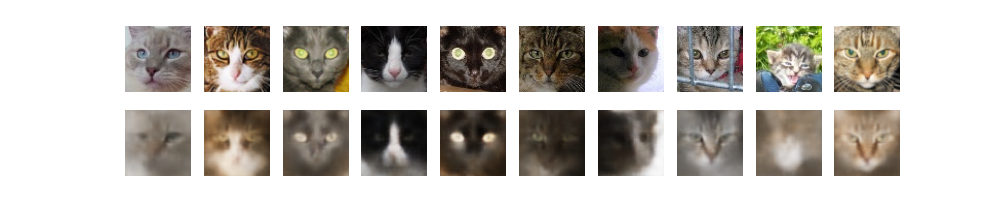

In [11]:
test_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

vae_cats.visualize_reconstructions(trained_model, test_loader)

# Generate new cats

In [12]:
plot_samples = 10
num_samples = 100  # Number of digits you want to generate
z, generated_cats = vae_cats.generate_new_cats(trained_model, num_samples)

torch.Size([100, 3, 64, 64])


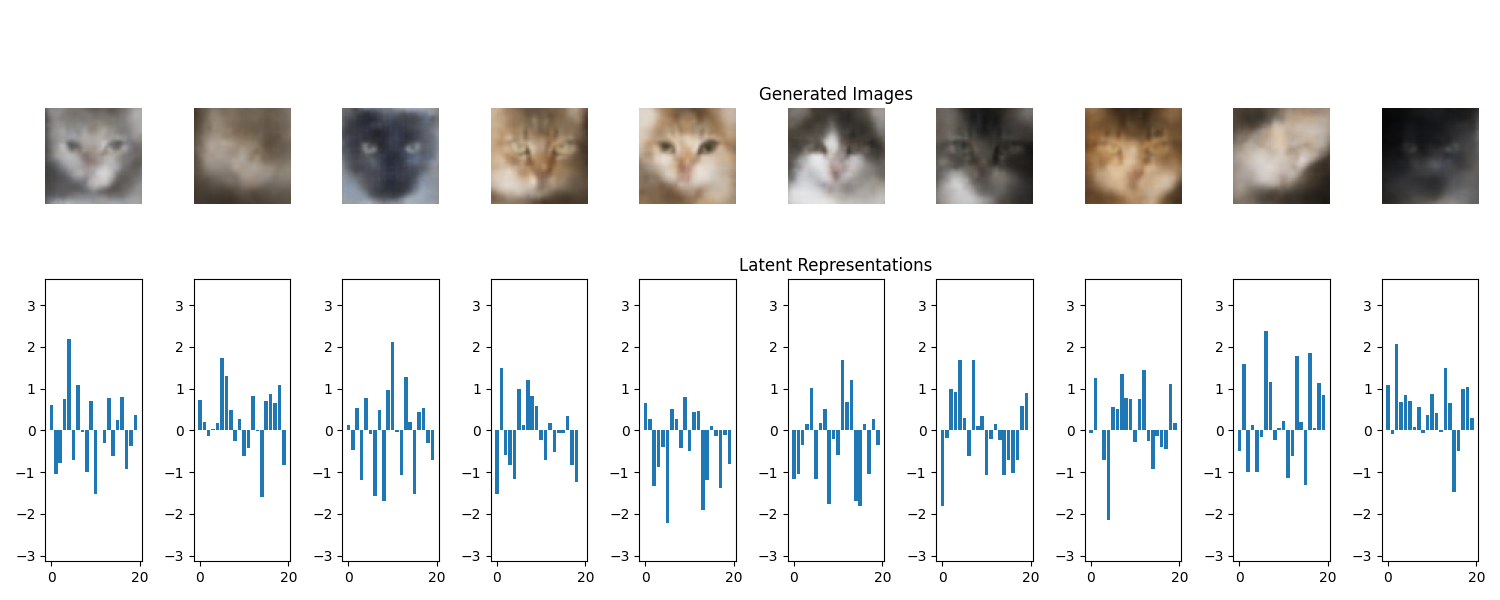

In [13]:
vae_cats.plot_images_and_latents(z, generated_cats, plot_samples)

# Project the latent space into 2d space (using t-NSE alg)

In [14]:
project_loader = DataLoader(dataset, batch_size=1000, shuffle=True)

# Get a batch of data
data, labels = next(iter(project_loader))
data = data.to(device)
labels = labels.numpy()  

# Use the encoder to get the latent variables
trained_model.eval()
with torch.no_grad():
    mu, _ = trained_model.encode(data)
    mu = mu.cpu().numpy()  # Convert to NumPy array for visualization

In [15]:
new_labels = np.concatenate([labels, [11 for i in range(plot_samples)]])

In [16]:
tsne = TSNE(n_components=2, random_state=0)
full_latent_vectors = np.vstack([mu, z[0:plot_samples]])
latent_tsne = tsne.fit_transform(full_latent_vectors)  # Use latent space representations for visualization

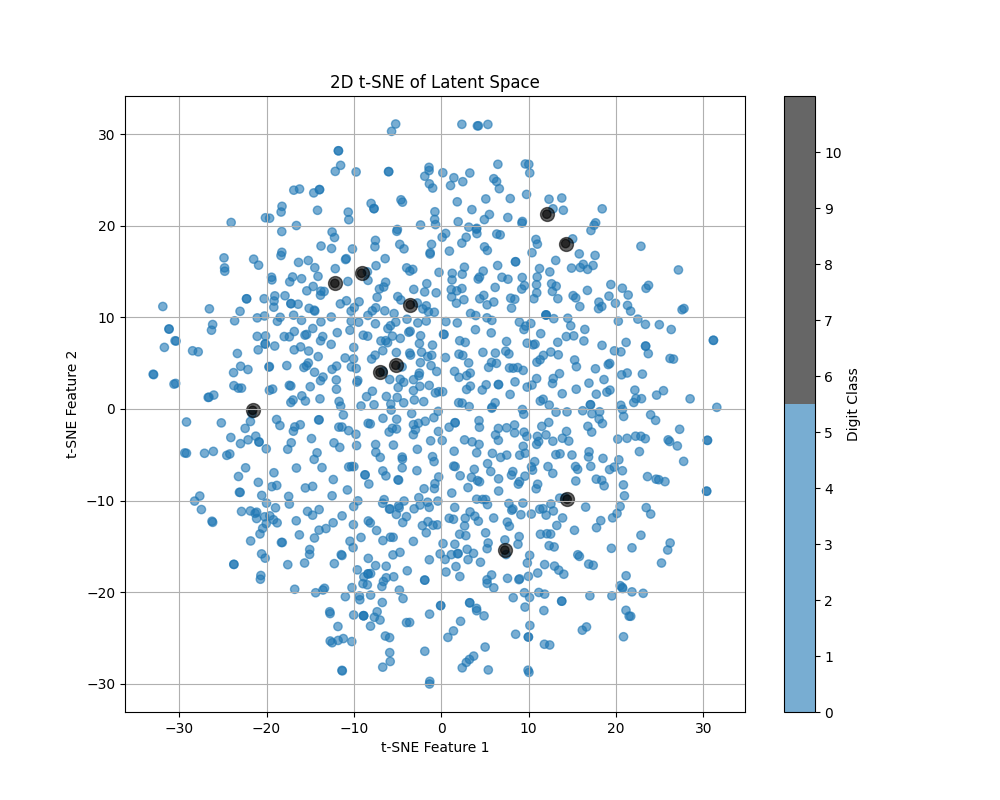

In [17]:
plt.close('all')
fig, ax = plt.subplots(1,1, figsize=(10, 8))

colors = ['#1f77b4', '#000000']
custom_cmap = ListedColormap(colors)

scatter = ax.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=new_labels, cmap=custom_cmap, alpha=0.6)
ax.scatter(latent_tsne[-plot_samples:, 0], latent_tsne[-plot_samples:, 1], c='k', s=100, alpha=0.6)

fig.colorbar(scatter, ticks=range(11), label='Digit Class')
ax.set_title('2D t-SNE of Latent Space')
ax.set_xlabel('t-SNE Feature 1')
ax.set_ylabel('t-SNE Feature 2')
ax.grid(True)
plt.show()